In [792]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from google.colab import drive
from google.colab import files
import statsmodels.api as sm
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import re
import sklearn
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import math
import random


#Test
#new

In [793]:
# from google.colab import drive
# drive.mount('/content/drive')

In [794]:
#reading data 
dfMain=pd.read_csv('AB_NYC_2019.csv')
df = dfMain.copy()
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Data Preprocessing

In [795]:
df.dropna()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,1,1,2019-07-07,1.00,1,147
48790,36427429,No.2 with queen size bed,257683179,H Ai,Queens,Flushing,40.75104,-73.81459,Private room,45,1,1,2019-07-07,1.00,6,339
48799,36438336,Seas The Moment,211644523,Ben,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,1,1,2019-07-07,1.00,1,87
48805,36442252,1B-1B apartment near by Metro,273841667,Blaine,Bronx,Mott Haven,40.80787,-73.92400,Entire home/apt,100,1,2,2019-07-07,2.00,1,40


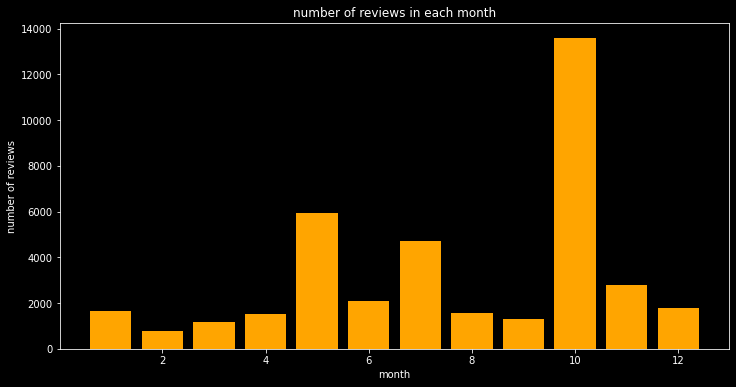

In [796]:
dfBackUp = df.copy()
df['last_review'] = pd.to_datetime(df['last_review'])
df['last_review_month'] = pd.DatetimeIndex(df['last_review']).month
monthes = df['last_review_month'].dropna()
monthes.value_counts()
plt.figure(figsize=(12,6))
plt.bar(x=monthes.unique() ,height=monthes.value_counts()  , color= 'orange')
plt.title('number of reviews in each month')
plt.xlabel('month')
plt.ylabel('number of reviews')
plt.show()
df = dfBackUp

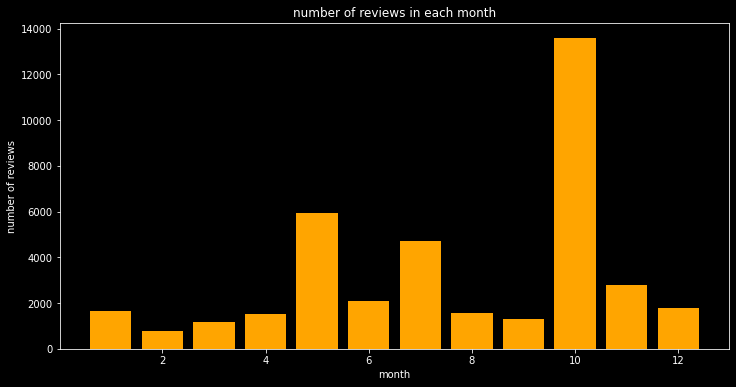

In [797]:
plt.figure(figsize=(12,6))
plt.bar(x=monthes.unique() ,height=monthes.value_counts()  , color= 'orange')
plt.title('number of reviews in each month')
plt.xlabel('month')
plt.ylabel('number of reviews')
plt.show()

In [798]:
dfMain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [799]:
df['last_review'].value_counts()

2019-06-23    1413
2019-07-01    1359
2019-06-30    1341
2019-06-24     875
2019-07-07     718
              ... 
2015-01-10       1
2016-01-24       1
2014-05-02       1
2014-11-06       1
2014-12-30       1
Name: last_review, Length: 1764, dtype: int64

the columns are :

-id : listing ID

-name : name of the listing

-host ID

-host_name

-neighbourhood_group : location

-neighbourhood : area 

-latitude : latitude coordinates

-longitude : longitude coordinates

-room_type 

-price : price in dollars

-minimum_nights 

-number_of_reviews

-last_review : the date of last history

-reviews_per_month

-calculated_host_listings_count : number of lisiting for the host

-availability_365 : number of available days in year

##Handling nulls

In [800]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

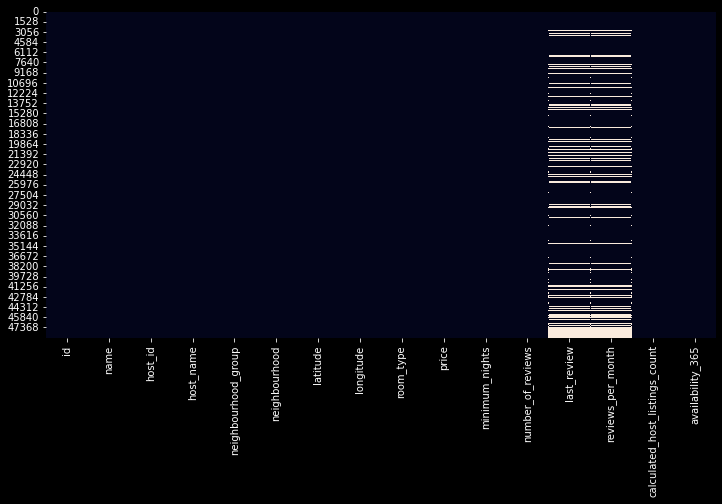

In [801]:
sns.heatmap(df.isnull(), cbar = False)

In [802]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

As shown before, the nulls are only in'last_review' and 'reviews_per_month' and these nulls are results of 0s in 'number_of_reviews' 

so now 'number_of_reviews' will be filled by 0

In [803]:
df['reviews_per_month'].replace(np.nan , 0 , inplace=True)

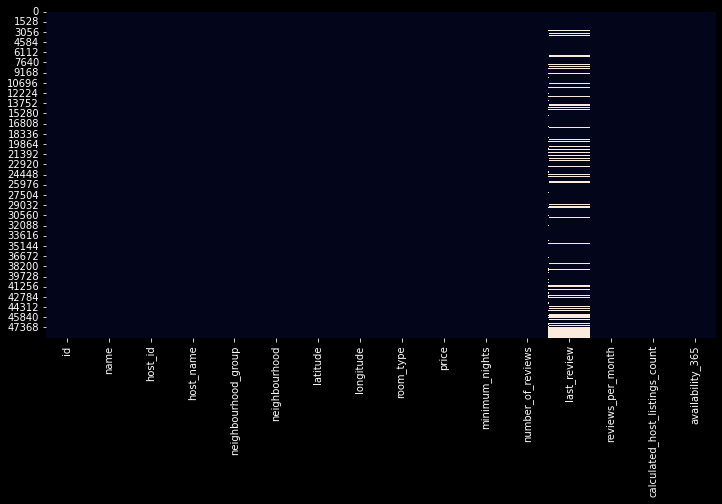

In [804]:
sns.heatmap(df.isnull(), cbar = False)

now the 'last_review' for the samples that have no reviews will be filled

but first it`s better to be categorized by year and season

then the nulls will be filled by 'no reviews' 

In [805]:
# determining the rows season from its month
SP = df['last_review'].str.extract(r'(\d+-0[3-5]-\d+)').dropna()
SU = df['last_review'].str.extract(r'(\d+-0[6-8]-\d+)').dropna()
AU = df['last_review'].str.extract(r'(\d+-(?:09|10|11)-\d+)').dropna()
WI = df['last_review'].str.extract(r'(\d+-(?:12|01|02)-\d+)').dropna()

In [806]:
WI_values = [re.sub(r'\d+-\d+-\d+' , 'Winter-' + str(x)[0:4]  , str(x)) for x in dfMain['last_review'][WI.index]  ] 
SP_values = [re.sub(r'\d+-\d+-\d+' , 'Spring-' + str(x)[0:4]  , str(x)) for x in dfMain['last_review'][SP.index]  ] 
SU_values = [re.sub(r'\d+-\d+-\d+' , 'Summer-' + str(x)[0:4]  , str(x)) for x in dfMain['last_review'][SU.index]  ] 
AU_values = [re.sub(r'\d+-\d+-\d+' , 'Autumn-' + str(x)[0:4]  , str(x)) for x in dfMain['last_review'][AU.index]  ] 


In [807]:
# assigning the values 
df['last_review'][WI.index] = WI_values
df['last_review'][SP.index] = SP_values
df['last_review'][SU.index] = SU_values
df['last_review'][AU.index] = AU_values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [808]:
#filling nulls with 'no reviews' 
df['last_review'].replace(np.nan , 'no reviews' , inplace = True) 

In [809]:
df['last_review'].value_counts()

Summer-2019    17326
no reviews     10052
Spring-2019     5973
Winter-2019     1910
Autumn-2018     1909
Winter-2018     1642
Summer-2018     1576
Autumn-2017      934
Spring-2018      923
Summer-2017      919
Summer-2016      895
Winter-2017      815
Autumn-2016      703
Winter-2016      614
Autumn-2015      585
Spring-2017      537
Spring-2016      495
Summer-2015      398
Winter-2015      287
Spring-2015      123
Autumn-2014       77
Summer-2014       63
Spring-2014       31
Winter-2014       28
Autumn-2013       18
Spring-2013       12
Autumn-2012       11
Summer-2013        9
Winter-2013        9
Summer-2012        7
Winter-2012        6
Spring-2011        3
Winter-2011        2
Autumn-2011        2
Spring-2012        1
Name: last_review, dtype: int64

In [810]:
df.dropna(inplace= True)

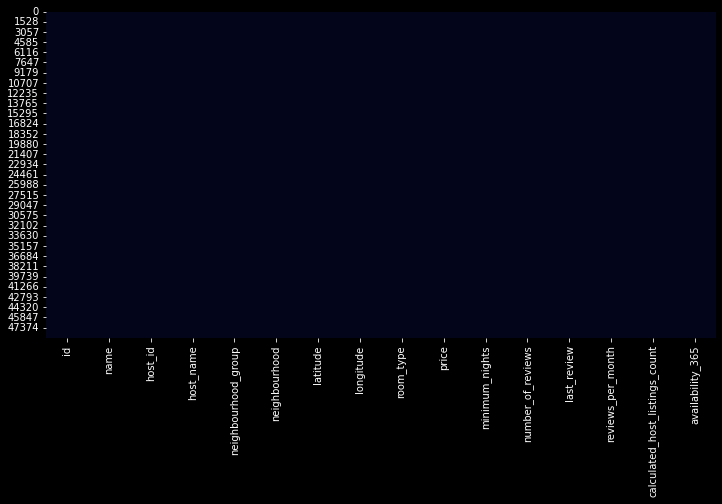

In [811]:
sns.heatmap(df.isnull(), cbar = False)

##encoding and labling

In [812]:
df_encoded = df.copy()

###encoding 'last_review'

this column will be encoded keeping its timing orders and 'no reviews' will be 0 

In [813]:
seasons = ['Winter' , 'Spring' , 'Summer' , 'Autumn' ]
code = 1
for year in range(2011 ,2020):
  for season in seasons :
    df_encoded['last_review'].replace(str(season)+'-'+str(year) , code , inplace=True)
    code += 1

df_encoded['last_review'].replace('no reviews' , 0 , inplace = True)

In [814]:
df_encoded['last_review'].value_counts()

35    17321
0     10037
34     5972
32     1909
33     1908
29     1641
31     1574
28      934
30      923
27      919
23      894
25      813
24      702
21      612
20      584
26      537
22      495
19      395
17      286
18      123
16       77
15       63
14       31
13       28
12       18
10       12
8        11
9         9
11        9
7         7
5         6
2         3
4         2
1         2
6         1
Name: last_review, dtype: int64

In [815]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48858 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48858 non-null  int64  
 1   name                            48858 non-null  object 
 2   host_id                         48858 non-null  int64  
 3   host_name                       48858 non-null  object 
 4   neighbourhood_group             48858 non-null  object 
 5   neighbourhood                   48858 non-null  object 
 6   latitude                        48858 non-null  float64
 7   longitude                       48858 non-null  float64
 8   room_type                       48858 non-null  object 
 9   price                           48858 non-null  int64  
 10  minimum_nights                  48858 non-null  int64  
 11  number_of_reviews               48858 non-null  int64  
 12  last_review                     

###encoding 'room_type'

In [816]:
df_encoded['room_type'] = df_encoded['room_type'].astype('category').cat.codes
print(f'\nbefore:\n')
print(df['room_type'].value_counts())
print(f'\nafter:\n')
print(df_encoded['room_type'].value_counts())



before:

Entire home/apt    25393
Private room       22306
Shared room         1159
Name: room_type, dtype: int64

after:

0    25393
1    22306
2     1159
Name: room_type, dtype: int64


In [817]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48858 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48858 non-null  int64  
 1   name                            48858 non-null  object 
 2   host_id                         48858 non-null  int64  
 3   host_name                       48858 non-null  object 
 4   neighbourhood_group             48858 non-null  object 
 5   neighbourhood                   48858 non-null  object 
 6   latitude                        48858 non-null  float64
 7   longitude                       48858 non-null  float64
 8   room_type                       48858 non-null  int8   
 9   price                           48858 non-null  int64  
 10  minimum_nights                  48858 non-null  int64  
 11  number_of_reviews               48858 non-null  int64  
 12  last_review                     

##one-hot encoding 'neighbourhood_group'

In [818]:
df['neighbourhood_group'].value_counts()

Manhattan        21643
Brooklyn         20089
Queens            5664
Bronx             1089
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [819]:
oneHotEncoder = pd.get_dummies(df_encoded['neighbourhood_group'])

In [820]:
df_encoded = df_encoded.join(oneHotEncoder)

#EDA

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


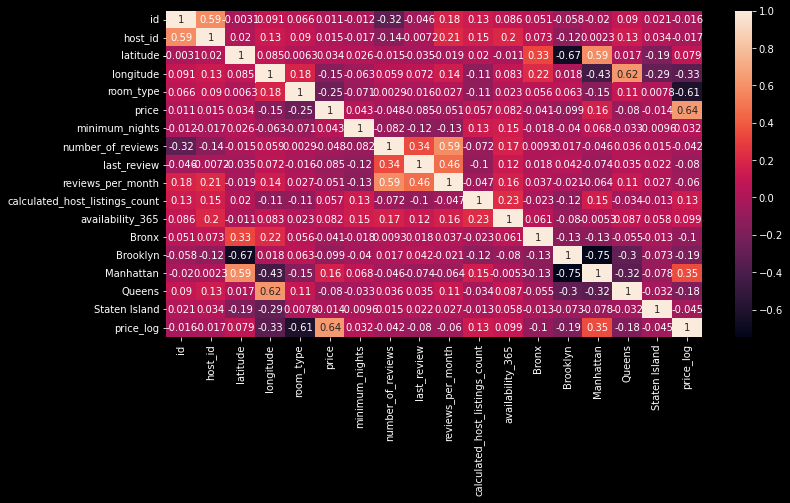

In [821]:
# df_encoded.drop(['id' , 'host_id'] ,axis=1 , inplace=True)
df_encoded['price_log'] = np.log(df_encoded['price'])
plt.figure(figsize=(12, 6))
plt.style.use('dark_background')
sns.heatmap( df_encoded.corr() , annot = True )
plt.show()

In [878]:
df_encoded.corr()

,id,host_id,latitude,longitude,room_type,price,minimum_nights,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,price_log,finite
id,1.000000,0.588247,-0.003106,0.091062,0.066079,0.010585,-0.012042,-0.046116,0.180113,0.133227,0.085616,0.051249,-0.057850,-0.019706,0.090265,0.020560,-0.015794,NaN
host_id,0.588247,1.000000,0.020168,0.127165,0.090334,0.015312,-0.017055,-0.007235,0.209612,0.154953,0.203684,0.072920,-0.115895,0.002327,0.131512,0.034473,-0.017448,NaN
latitude,-0.003106,0.020168,1.000000,0.084861,0.006387,0.033904,0.025917,-0.034786,-0.018664,0.019548,-0.010733,0.330418,-0.672864,0.590739,0.017134,-0.190985,0.079462,NaN
longitude,0.091062,0.127165,0.084861,1.000000,0.184067,-0.149889,-0.062919,0.071545,0.138678,-0.114748,0.082692,0.221243,0.017513,-0.433370,0.622868,-0.291944,-0.326030,NaN
room_type,0.066079,0.090334,0.006387,0.184067,1.000000,-0.249223,-0.070665,-0.016136,0.026580,-0.106092,0.022508,0.056166,0.062651,-0.149034,0.106942,0.007786,-0.613162,NaN
price,0.010585,0.015312,0.033904,-0.149889,-0.249223,1.000000,0.042810,-0.085234,-0.050552,0.057450,0.081836,-0.040977,-0.098445,0.163840,-0.080256,-0.013861,0.638186,NaN
minimum_nights,-0.012042,-0.017055,0.025917,-0.062919,-0.070665,0.042810,1.000000,-0.120377,-0.127342,0.131315,0.145924,-0.018434,-0.039883,0.067985,-0.033093,-0.009557,0.032205,NaN
last_review,-0.046116,-0.007235,-0.034786,0.071545,-0.016136,-0.085234,-0.120377,1.000000,0.464044,-0.100946,0.118682,0.018026,0.042226,-0.073432,0.034875,0.021538,-0.079753,NaN
reviews_per_month,0.180113,0.209612,-0.018664,0.138678,0.026580,-0.050552,-0.127342,0.464044,1.000000,-0.047375,0.163683,0.036406,-0.021499,-0.063834,0.108050,0.026657,-0.060423,NaN
calculated_host_listings_count,0.133227,0.154953,0.019548,-0.114748,-0.106092,0.057450,0.131315,-0.100946,-0.047375,1.000000,0.225795,-0.022500,-0.123286,0.152914,-0.033920,-0.012851,0.132679,NaN


![map_boroughs.gif](attachment:map_boroughs.gif)

Manhattan        21643
Brooklyn         20089
Queens            5664
Bronx             1089
Staten Island      373
Name: neighbourhood_group, dtype: int64


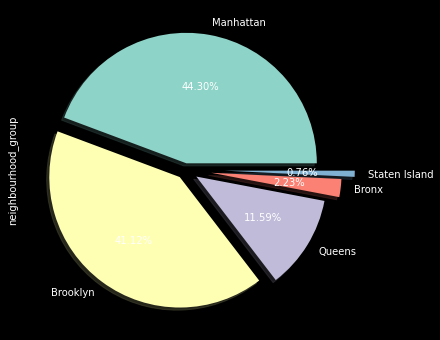

In [822]:
print(df['neighbourhood_group'].value_counts())
round(df['neighbourhood_group'].value_counts()/df.shape[0]*100,2).plot.pie(autopct='%1.2f%%',shadow = True, explode = [0.05, 0.07,0.1,0.2,0.3])

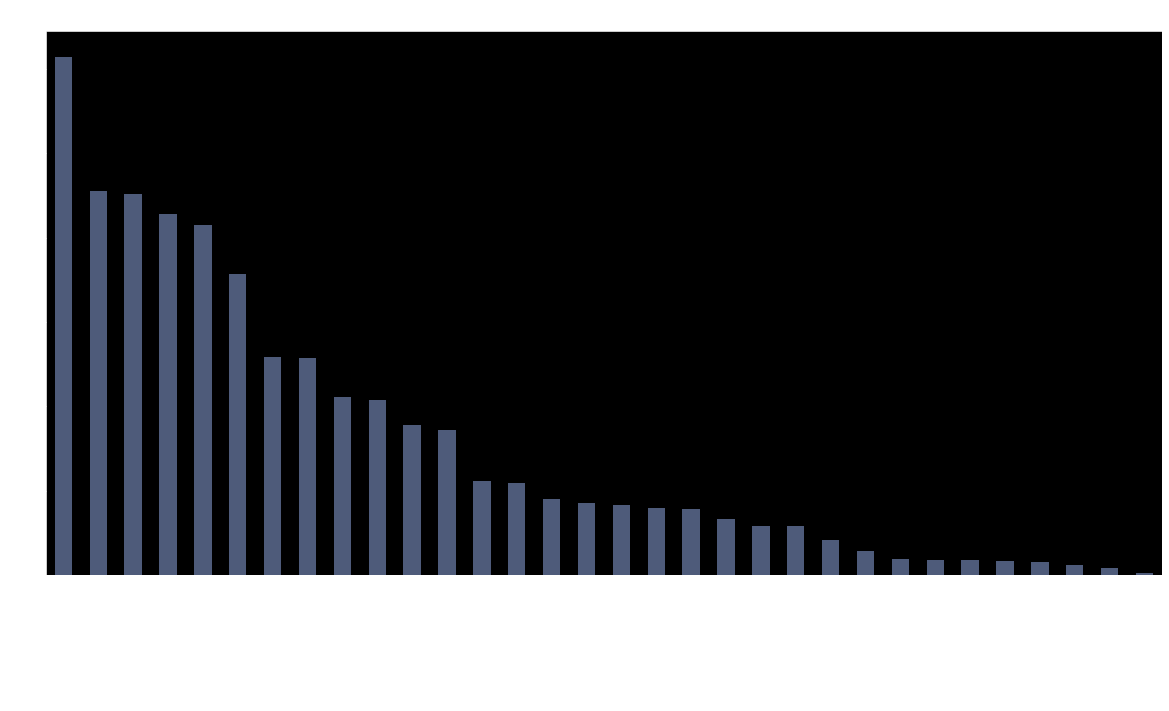

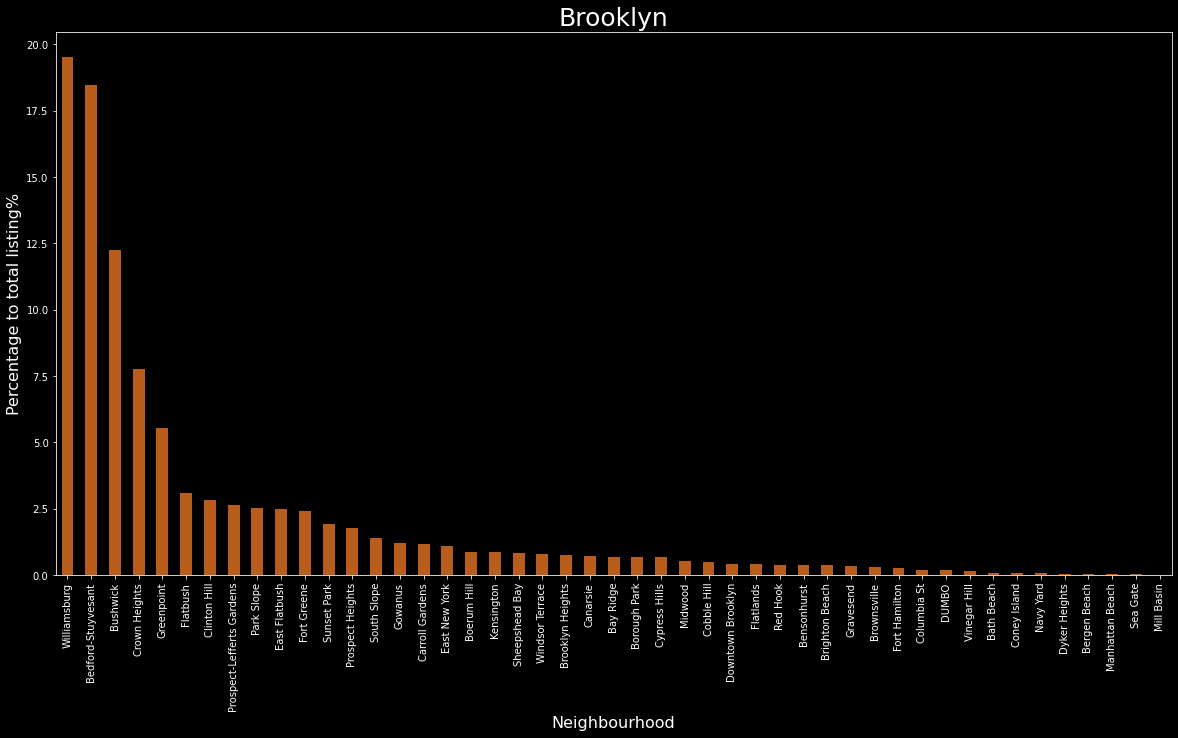

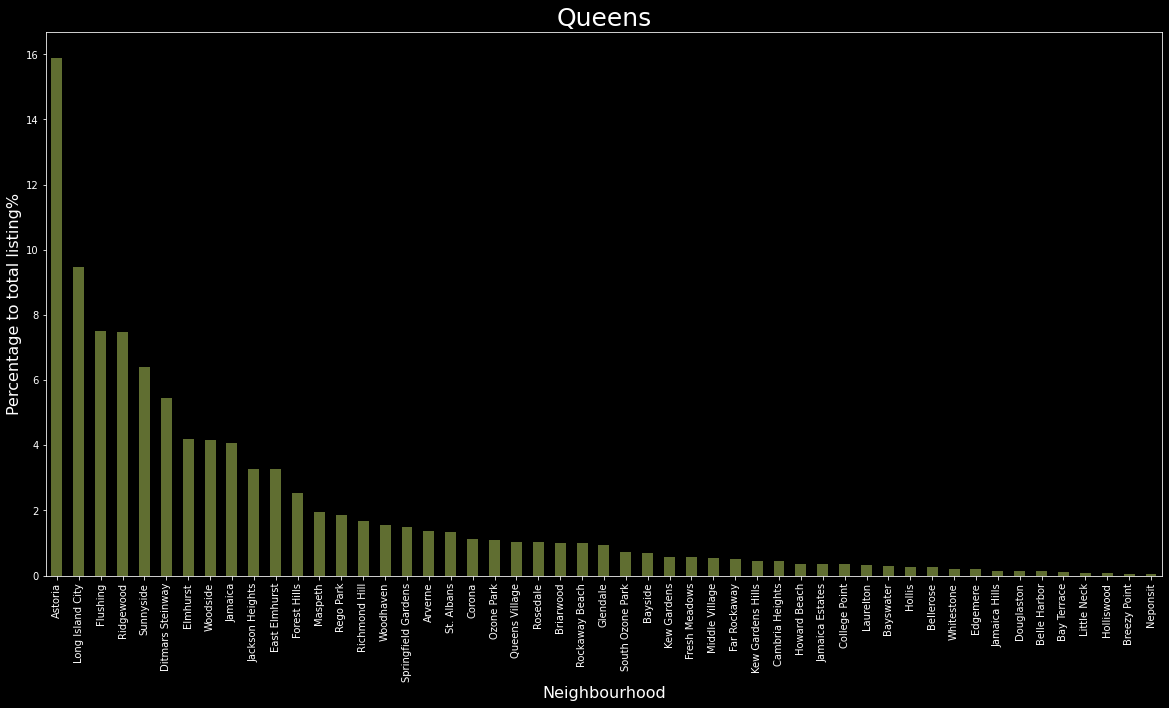

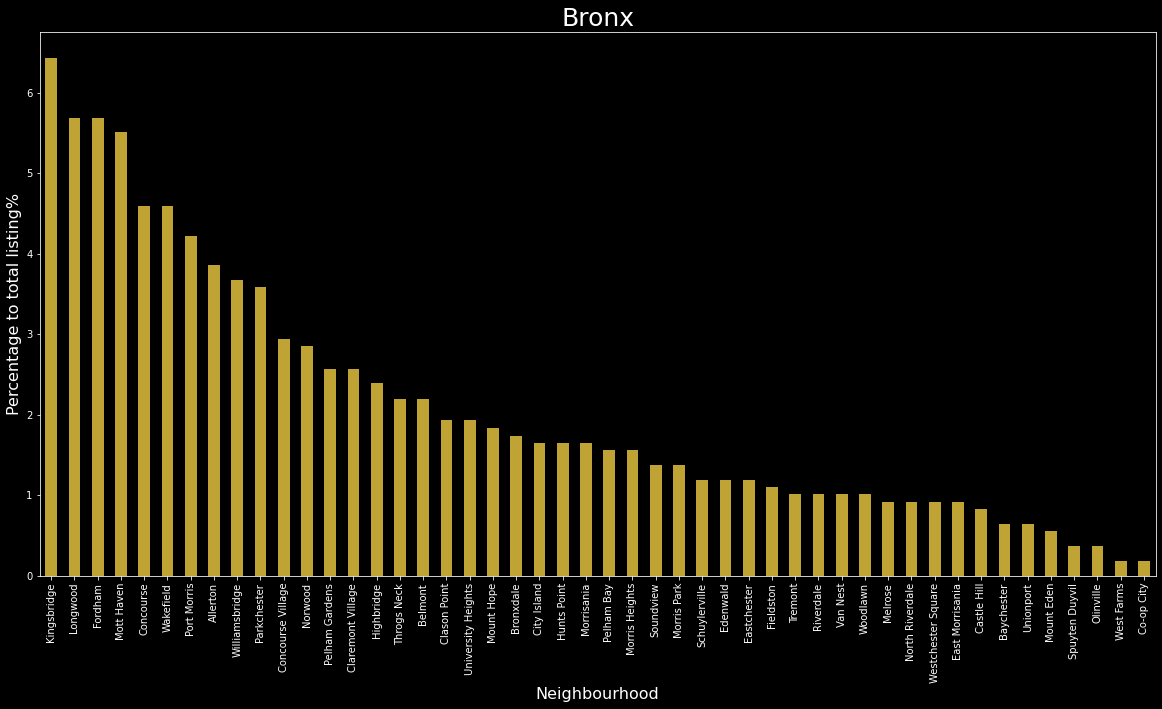

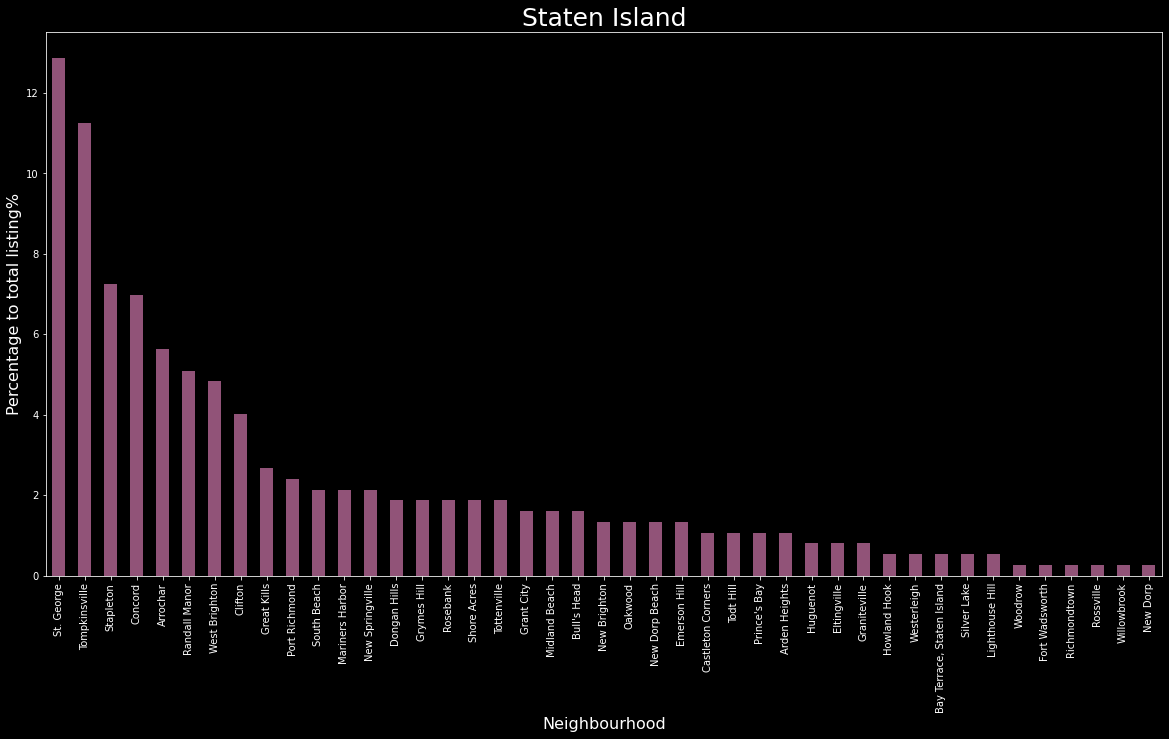

In [823]:
plt.figure(figsize=(20,10),facecolor='White')
plt.title('Manhattan',fontsize=25)
plt.xlabel('Neighbourhood', fontsize=16)
plt.ylabel('Percentage to total listing%', fontsize=16)
n1 = df[df['neighbourhood_group']=='Manhattan']
round(n1['neighbourhood'].value_counts()/n1.shape[0]*100,2).plot.bar(color='#4e5b7a')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Brooklyn',fontsize=25)
plt.xlabel('Neighbourhood', fontsize=16)
plt.ylabel('Percentage to total listing%', fontsize=16)
n2 = df[df['neighbourhood_group']=='Brooklyn']
round(n2['neighbourhood'].value_counts()/n2.shape[0]*100,2).plot.bar(color='#b85d1c')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Queens',fontsize=25)
plt.xlabel('Neighbourhood', fontsize=16)
plt.ylabel('Percentage to total listing%', fontsize=16)
n3 = df[df['neighbourhood_group']=='Queens']
round(n3['neighbourhood'].value_counts()/n3.shape[0]*100,2).plot.bar(color='#606e31')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Bronx',fontsize=25)
plt.xlabel('Neighbourhood', fontsize=16)
plt.ylabel('Percentage to total listing%', fontsize=16)
n4 = df[df['neighbourhood_group']=='Bronx']
round(n4['neighbourhood'].value_counts()/n4.shape[0]*100,2).plot.bar(color='#bfa334')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Staten Island',fontsize=25)
plt.xlabel('Neighbourhood', fontsize=16)
plt.ylabel('Percentage to total listing%', fontsize=16)
n5 = df[df['neighbourhood_group']=='Staten Island']
round(n5['neighbourhood'].value_counts()/n5.shape[0]*100,2).plot.bar(color='#915378')
plt.show()

Entire home/apt    25393
Private room       22306
Shared room         1159
Name: room_type, dtype: int64


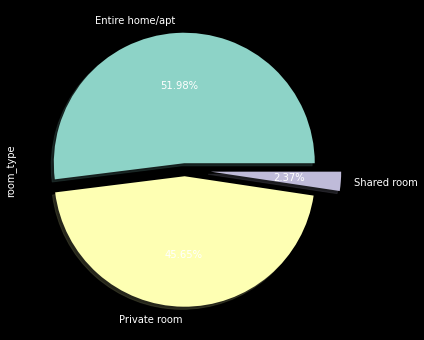

In [824]:
print(df['room_type'].value_counts())
round(df['room_type'].value_counts()/df.shape[0]*100,2).plot.pie(autopct='%1.2f%%',shadow = True, explode = [0.05, 0.05,0.2])

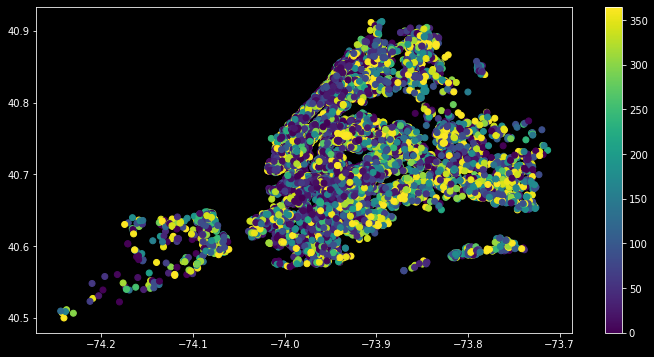

In [825]:
plt.scatter(data = df , x="longitude" , y="latitude" , c =df["availability_365"]  )
plt.colorbar ()
plt.show()

# ML

In [826]:
df_encoded['Bronx'] = df_encoded['Bronx'].astype('int64')
df_encoded['Brooklyn'] = df_encoded['Brooklyn'].astype('int64')
df_encoded['Manhattan'] = df_encoded['Manhattan'].astype('int64')
df_encoded['Queens'] = df_encoded['Queens'].astype('int64')
df_encoded['Staten Island'] = df_encoded['Staten Island'].astype('int64')
df_encoded['price_log'] = df_encoded['price_log'].astype('float32')


In [827]:
df_encoded.drop('number_of_reviews' ,axis=1 , inplace = True)

In [828]:
X_features = df_encoded.drop(['price_log' , 'price' , 'id' , 'name' , 'host_id' ,'host_name' , 'neighbourhood_group' , 'neighbourhood'] , axis = 1).columns
X_features

Index(['latitude', 'longitude', 'room_type', 'minimum_nights', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island'],
      dtype='object')

In [829]:
df_encoded['finite'] = [math.isfinite(x) for x in df_encoded['price_log']]

In [830]:
df_encoded.drop(df_encoded[df_encoded['finite'] == False].index , inplace = True)

In [831]:
X = df_encoded.drop(['price_log' , 'price' , 'id' , 'name' , 'host_id' ,'host_name' , 'neighbourhood_group' , 'neighbourhood'] , axis = 1)
y = df_encoded['price_log']

In [832]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25 , random_state=13)

In [833]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [834]:
lr.score(X_train,y_train)

0.4944277311758841

In [857]:
lr.score(X_test , y_test)

0.48567505265868205

In [870]:
# RFR_Max_Features = [x for x in range(8 , 12)]
# RFR_Max_Depth = [x for x in range(7 , 11)]
# RMSEs = []
# train_score = []
# test_score = []
# R2s = []

In [871]:
# for max_fraures  in RFR_Max_Features :
#   for max_depth in RFR_Max_Depth:
#     RFR = RandomForestRegressor(max_depth=max_depth , max_features=max_fraures)
#     RFR.fit(X_train, y_train )
#     predictions = RFR.predict(X_test)
#     MSE = mean_squared_error(y_test, predictions)
#     RMSE = math.sqrt(MSE)
#     RMSEs.append(RMSE)
#     train_score.append(RFR.score(X_train , y_train) )
#     test_score.append(RFR.score(X_test , y_test))
#     R2s.append(r2_score(y_test, predictions))



In [ ]:
# train_score

In [ ]:
# test_score

In [ ]:
# R2s

In [ ]:
# x=np.array(RFR_Max_Features)
# y=np.array(RFR_Max_Depth)
# z = train_score
# X,Y = np.meshgrid(x,y)

# Z = np.reshape(z, (len(x), len(y)))

# plt.pcolormesh(X,Y,Z)

# plt.show()

In [ ]:
# X

In [ ]:
# sns.heatmap()

In [ ]:
# fig , ax  = plt.subplots(1 , 3 , figsize = (6,6))
# ax[0].plot(train_score)




In [689]:
RFR = RandomForestRegressor(max_depth=10 , max_features=7)

In [690]:
RFR.fit(X_train, y_train )

RandomForestRegressor(max_depth=10, max_features=7)

In [880]:
predictions = RFR.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
RMSE = math.sqrt(MSE)
print('MAE: ' + str(mean_absolute_error(y_test, predictions)))
print('MSE: ' + str(MSE))
print('RMSE: ' + str(RMSE))
print('Score: '+ str(r2_score(y_test, predictions)))


MAE: 0.32137893450552435
MSE: 0.20149286474234246
RMSE: 0.4488795659665769
Score: 0.5850109022338514


In [881]:
print(RFR.score(X_train, y_train))

0.6784549507956212


In [882]:
print(RFR.score(X_test, y_test))

0.5850109022338514


In [883]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [884]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [885]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [886]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[16:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [887]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

0.4546616

In [888]:
xg_reg.score(X_train , y_train)

0.5946375393751626

In [889]:
xg_reg.score(X_test , y_test)

0.5742510588778161

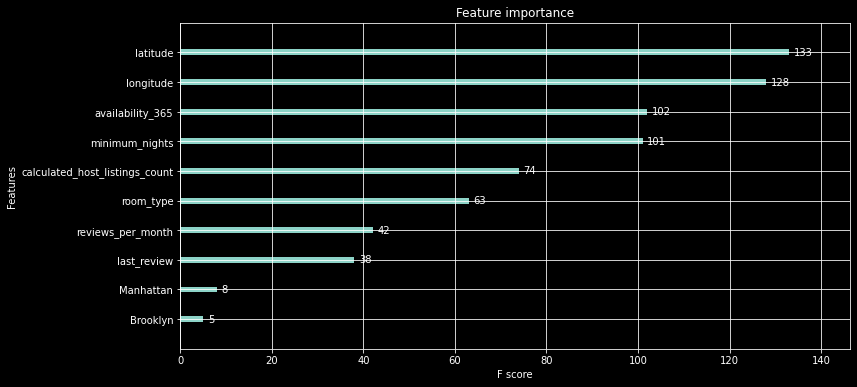

In [890]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12 , 6]
plt.show()